<a href="https://colab.research.google.com/github/aem210/computer-vision-using-deep-learning/blob/main/ConvLSTM2D_on_Introduction_to_Video_Classification_and_Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Here are the steps we will perform:

Step 1: Download and Extract the Dataset
Step 2: Visualize the Data with its Labels
Step 3: Read and Preprocess the Dataset
Step 4: Split the Data into Train and Test Set
Step 5: Construct the Model
Step 6: Compile & Train the Model
Step 7: Plot Model’s Loss & Accuracy Curves
Step 8: Make Predictions with the Model
Step 9: Using Single-Frame CNN Method 

In [1]:
#The Dataset we are using is the UCF101 – Action Recognition Dataset.

#UCF101 is an action recognition dataset 

!pip install pafy youtube-dl moviepy
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
#!pip install tensorflow
#!python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"



     |████████████████████████████████| 1.9MB 7.0MB/s 


In [2]:
# Import the necessary modules
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

#intro to video classification and human activity tracking install docs 
import cv2
import math
import pafy
import random
import datetime as dt
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping



from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1523712/45929032 bytes (3.3%)4186112/45929032 bytes (9.1%)7634944/45929032 bytes (16.6%)10878976/45929032 bytes (23.7%)14295040/45929032 bytes (31.1%)17596416/45929032 bytes (38.3%)21045248/45929032 bytes (45.8%)24346624/45929032 bytes (53.0%)27852800/45929032 bytes (60.6%)31096832/45929032 bytes (67.7%)34603008/45929032 bytes (75.3%)38019072/45929032 bytes (82.8%)4

In [3]:
#set Numpy, Python and Tensorflow seeds to get consistent results
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
#NOT: was not able to unrar the datastep so unzipped it on local computer 
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar x UCF101.rar -inul -y
#from rarfile import RarFile
#rar = RarFile('UCF50.rar')

--2021-07-15 06:20:37--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/rar]
Saving to: ‘UCF101.rar’

UCF101.rar          100%[===================>]   6.46G  15.3MB/s    in 7m 11s  

2021-07-15 06:27:49 (15.3 MB/s) - ‘UCF101.rar’ saved [6932971618/6932971618]



In [5]:
# Helper functions for the UCF101 dataset - this is from the Tensor Flow Example 

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

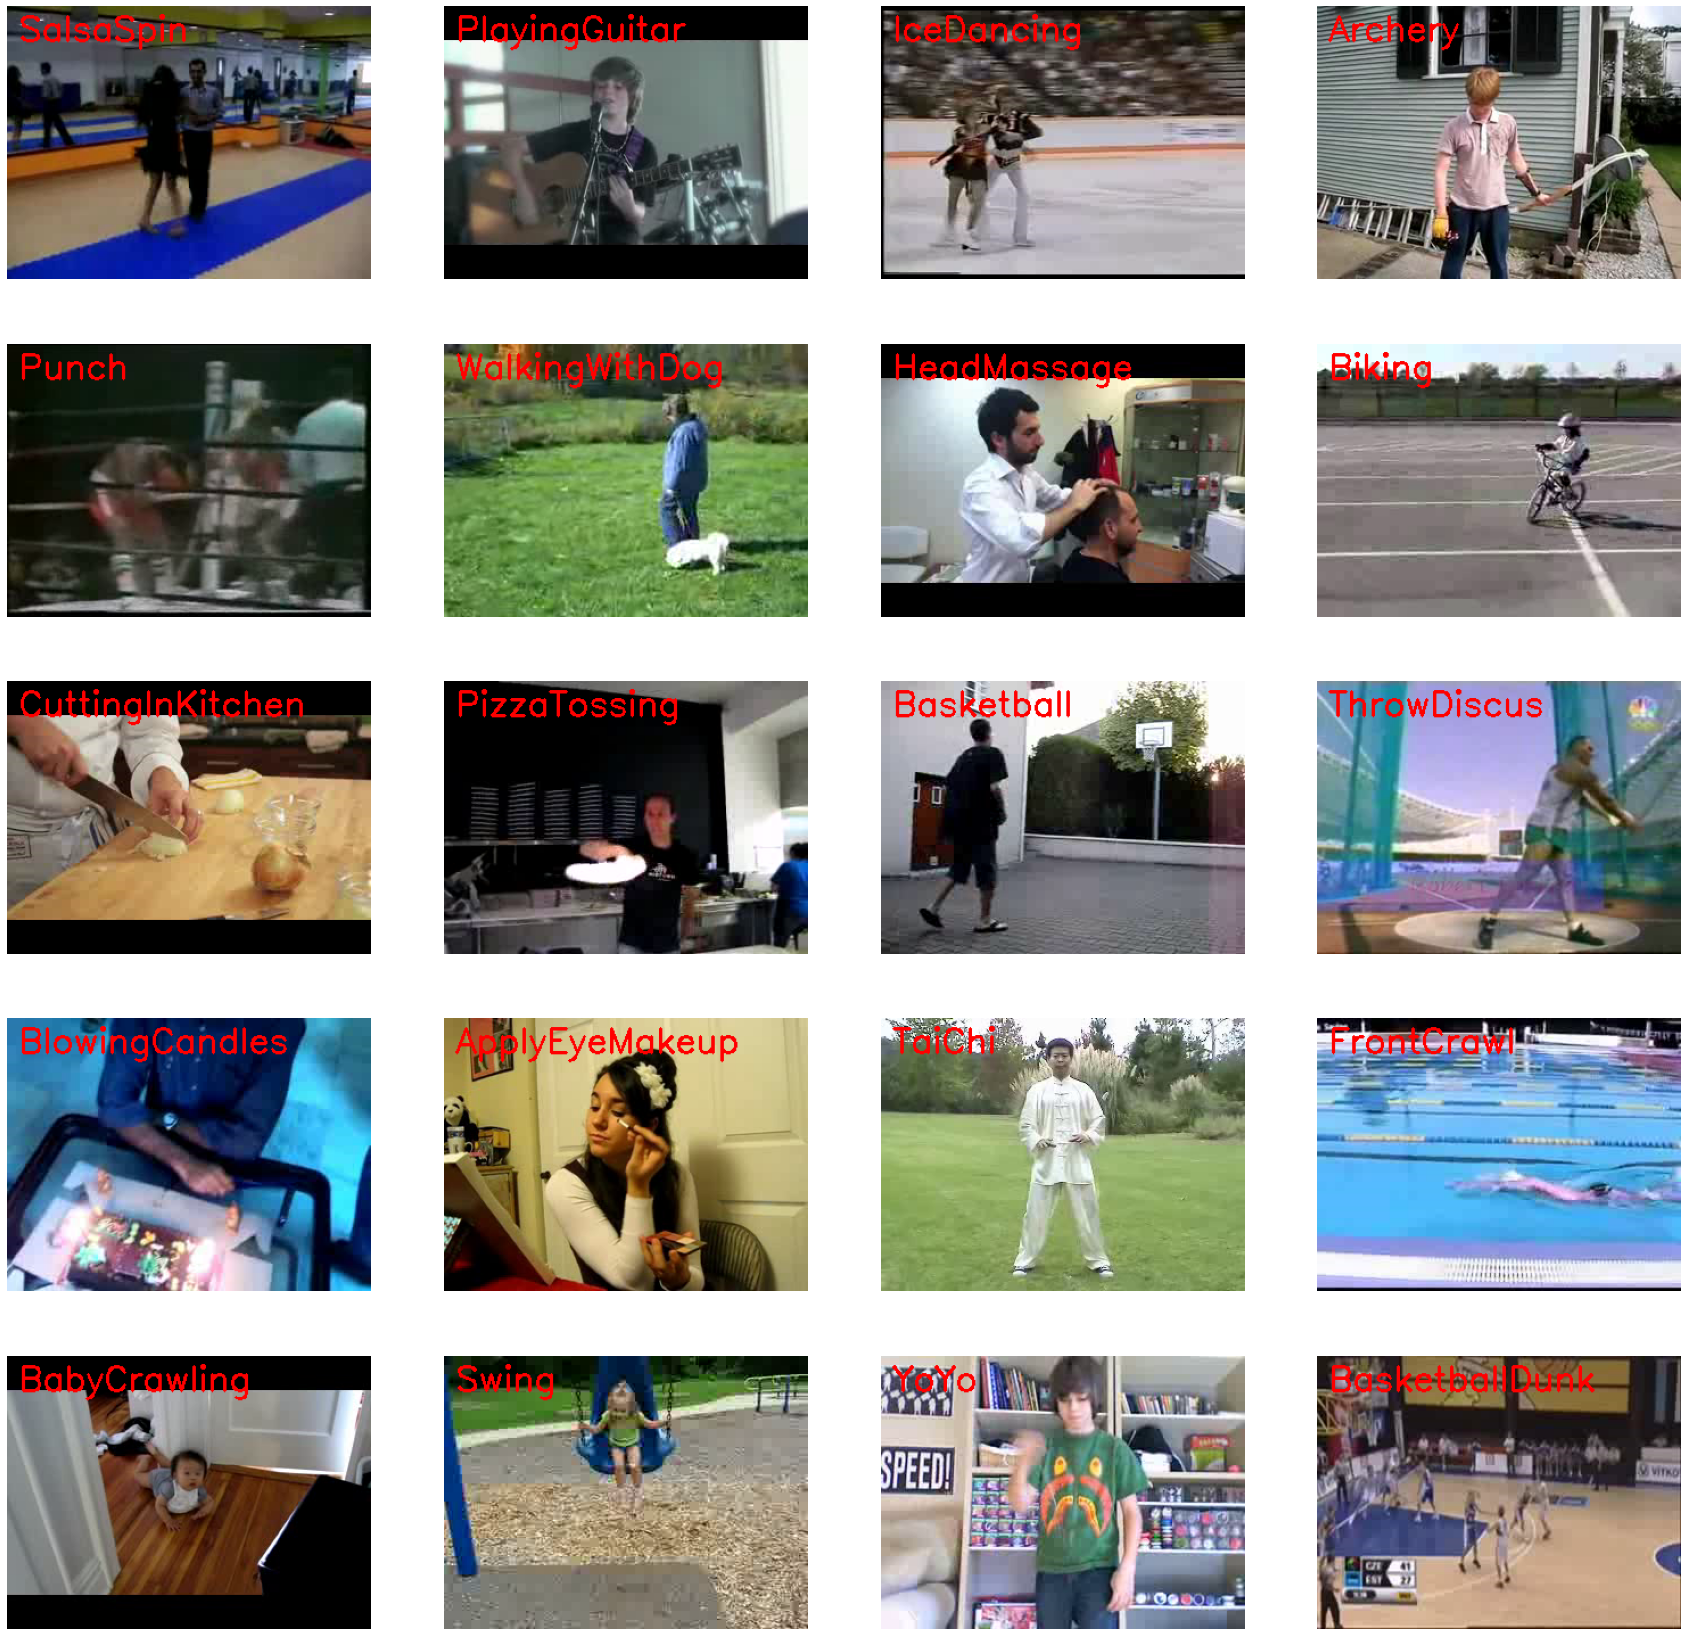

In [6]:
#Step 2: Visualize the Data with its Labels

# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF-101')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF-101/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [7]:
import shutil

#shutil.rmtree('UCF-101/{all_classes_names[50]}')

#classes_list = ['ApplyEyeMakeup', 'ApplyLipstick', 'BrushingTeeth', 'BlowDryHair']

#print(all_classes_names)

#print(sort(all_classes_names))

#video_files_names_list = os.listdir(f'UCF-101/{classes_list}')


#delete unnecessary direcotries 
shutil.rmtree('UCF-101/Archery')
shutil.rmtree('UCF-101/BabyCrawling')
shutil.rmtree('UCF-101/BalanceBeam')
shutil.rmtree('UCF-101/BandMarching')
shutil.rmtree('UCF-101/BaseballPitch')
shutil.rmtree('UCF-101/Basketball')
shutil.rmtree('UCF-101/BasketballDunk')
shutil.rmtree('UCF-101/BenchPress')
shutil.rmtree('UCF-101/Biking')
shutil.rmtree('UCF-101/Billiards')
shutil.rmtree('UCF-101/BlowingCandles')
shutil.rmtree('UCF-101/BodyWeightSquats')
shutil.rmtree('UCF-101/Bowling')
shutil.rmtree('UCF-101/BoxingPunchingBag')
shutil.rmtree('UCF-101/BoxingSpeedBag')
shutil.rmtree('UCF-101/BreastStroke')
shutil.rmtree('UCF-101/CleanAndJerk')
shutil.rmtree('UCF-101/CliffDiving')
shutil.rmtree('UCF-101/CricketBowling')
shutil.rmtree('UCF-101/CricketShot')
shutil.rmtree('UCF-101/CuttingInKitchen')
shutil.rmtree('UCF-101/Diving')
shutil.rmtree('UCF-101/Drumming')
shutil.rmtree('UCF-101/Fencing')
shutil.rmtree('UCF-101/FieldHockeyPenalty')
shutil.rmtree('UCF-101/FloorGymnastics')
shutil.rmtree('UCF-101/FrisbeeCatch')
shutil.rmtree('UCF-101/FrontCrawl')
shutil.rmtree('UCF-101/GolfSwing')
shutil.rmtree('UCF-101/Haircut')
shutil.rmtree('UCF-101/Hammering')
shutil.rmtree('UCF-101/HammerThrow')
shutil.rmtree('UCF-101/HandstandPushups')
shutil.rmtree('UCF-101/HandstandWalking')
shutil.rmtree('UCF-101/HeadMassage')
shutil.rmtree('UCF-101/HighJump')
shutil.rmtree('UCF-101/HorseRace')
shutil.rmtree('UCF-101/HorseRiding')
shutil.rmtree('UCF-101/HulaHoop')
shutil.rmtree('UCF-101/IceDancing')
shutil.rmtree('UCF-101/JavelinThrow')
shutil.rmtree('UCF-101/JugglingBalls')
shutil.rmtree('UCF-101/JumpingJack')
shutil.rmtree('UCF-101/JumpRope')
shutil.rmtree('UCF-101/Kayaking')
shutil.rmtree('UCF-101/Knitting')
shutil.rmtree('UCF-101/LongJump')
shutil.rmtree('UCF-101/Lunges')
shutil.rmtree('UCF-101/MilitaryParade')
shutil.rmtree('UCF-101/Mixing')
shutil.rmtree('UCF-101/MoppingFloor')
shutil.rmtree('UCF-101/Nunchucks')
shutil.rmtree('UCF-101/ParallelBars')
shutil.rmtree('UCF-101/PizzaTossing')
shutil.rmtree('UCF-101/PlayingCello')
shutil.rmtree('UCF-101/PlayingDaf')
shutil.rmtree('UCF-101/PlayingDhol')
shutil.rmtree('UCF-101/PlayingFlute')
shutil.rmtree('UCF-101/PlayingGuitar')
shutil.rmtree('UCF-101/PlayingPiano')
shutil.rmtree('UCF-101/PlayingSitar')
shutil.rmtree('UCF-101/PlayingTabla')
shutil.rmtree('UCF-101/PlayingViolin')
shutil.rmtree('UCF-101/PoleVault')
shutil.rmtree('UCF-101/PommelHorse')
shutil.rmtree('UCF-101/PullUps')
shutil.rmtree('UCF-101/Punch')
shutil.rmtree('UCF-101/PushUps')
shutil.rmtree('UCF-101/Rafting')
shutil.rmtree('UCF-101/RockClimbingIndoor'	)
shutil.rmtree('UCF-101/RopeClimbing')
shutil.rmtree('UCF-101/Rowing')
shutil.rmtree('UCF-101/SalsaSpin'	)
shutil.rmtree('UCF-101/ShavingBeard'	)
shutil.rmtree('UCF-101/Shotput'	)
shutil.rmtree('UCF-101/SkateBoarding')
shutil.rmtree('UCF-101/Skiing')
shutil.rmtree('UCF-101/Skijet')
shutil.rmtree('UCF-101/SkyDiving'	)
shutil.rmtree('UCF-101/SoccerJuggling')
shutil.rmtree('UCF-101/SoccerPenalty')
shutil.rmtree('UCF-101/StillRings'	)
shutil.rmtree('UCF-101/SumoWrestling'	)
shutil.rmtree('UCF-101/Surfing')
shutil.rmtree('UCF-101/Swing'	)
shutil.rmtree('UCF-101/TableTennisShot'	)
shutil.rmtree('UCF-101/TaiChi'	)
shutil.rmtree('UCF-101/TennisSwing'	)
shutil.rmtree('UCF-101/ThrowDiscus'	)
shutil.rmtree('UCF-101/TrampolineJumping'	)
shutil.rmtree('UCF-101/Typing'	)
shutil.rmtree('UCF-101/UnevenBars'	)
shutil.rmtree('UCF-101/VolleyballSpiking'	)
shutil.rmtree('UCF-101/WalkingWithDog'	)
shutil.rmtree('UCF-101/WallPushups'	)
shutil.rmtree('UCF-101/WritingOnBoard'	)
shutil.rmtree('UCF-101/YoYo'	)



# Step 3: Read and preprocess the dataset 
We need to preprocess the dataset as we are using a classifcation architecture to train on a video classification 
#dataset

Now w constants,

- image_height and image_weight: This is the size we will resize all frames of the video to, we're doing this to - avoid unneccsary computation.

- max_images_per_class: Maximum number of training images allowed for each class.

- dataset_directory: The path of the directory containing the extracted dataset.

- classes_list: These are the list of classes we're going to be training on, we're traninng on following 4 classes, you can feel free to change it.

        - apply eye makeup 
        - apply lipstick 
        - blow dry hair 
        - brush teeth 
Note: The image_height, image_weight and max_images_per_class constants may be increased for better results, but be warned this will become computationally expensive.

In [8]:
image_height, image_width = 64, 64
max_images_per_class = 70

dataset_directory = "UCF-101"
classes_list = ["ApplyEyeMakeup", "ApplyLipstick", "BrushingTeeth", "BlowDryHair"]

model_output_size = len(classes_list)



**Extract, Resize & Normalize Frames**

Create a function that extracts the frames from each video while performing other preprocessing operations like resizing and normal images.
This method takes the video file as an input. it then reads the video frame by frame into a list, and then finally returns that list


In [9]:


def frames_extraction(video_path):
    frames_list = []
     
    video_reader = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= max_images_per_class: 
         
        # Reading a frame from the video file 
        success, image = video_reader.read() 
        
        if success:
            # Resize the Frame to fixed Dimensions
            image = cv2.resize(image, (image_height, image_width))
            
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = image / 255

            # Appending the normalized frame into the frames list
            frames_list.append(normalized_frame)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

# Dataset Creation
Now we'll create another function called create_dataset(), this function uses the frames_extraction() function above and creates our final preprocessed dataset.

Here's how this function works:

1. Iterate through all the classes mentioned in the classes_list
2. Now for each class iterate through all the video files present in it.
3. Call the frame_extraction method on each video file.
4. Add the returned frames to a list called temp_features
5. After all videos of a class are processed, randomly select video frames (equal to max_images_per_class) and add them to the list called features.
6. Add labels of the selected videos to the labels list.
7. After all videos of all classes are processed then return the features and labels as numpy arrays.

So when you call this function, it returns 2 lists:

    - a list of feature vectors
    - a list of it's associated labels.

In [10]:
def create_dataset(input_dir):
    features = []
    labels = []
     
     # Iterating through all the classes mentioned in the classes list
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(input_dir, c))

        # Iterating through all the files present in the files list
        for f in files_list:
        
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            
            if len(frames) == max_images_per_class:
                
                 # Appending the frames to a temporary list.
                features.append(frames)
                
                # Adding Fixed number of labels to the labels list
                y = [0]*len(classes_list)
                y[classes_list.index(c)] = 1
                labels.append(y)
    
    # Converting the features and labels lists to arrays
    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels

In [11]:
#calling the ceate_dataset() function that will return the features and labels 
features, labels = create_dataset(dataset_directory)

BrushingTeeth
ApplyEyeMakeup
ApplyLipstick
BlowDryHair
Defected frame
Defected frame
Defected frame


# Step 4: Split the Data into Train and Test Set
Now we have 2 numpy arrays, one containing all images, the second one contains all class labels in one hot encoded format. Let’s split our data to create a training and a testing set. It’s important that you shuffle your data before the split which we have already done. 

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.2, shuffle = True, random_state = 0) 

# Step 5: Construct the Model 
Create the convLSTM model. This one is a uses the ConvLSTM2D Classification model 

In [13]:

# We will use a Sequential model for model construction
model = Sequential()
#input_shape = tf.keras.Input(shape = (max_images_per_class, image_height, image_width, 3))
    # Defining The Model Architecture
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape =(max_images_per_class, image_height, image_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(model_output_size, activation = "softmax"))


  # Printing the models summary
model.summary()




# Calling the create_model method




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 32)        40448     
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15745152  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 15,786,116
Trainable params: 15,786,116
Non-trainable params: 0
____________________________________________

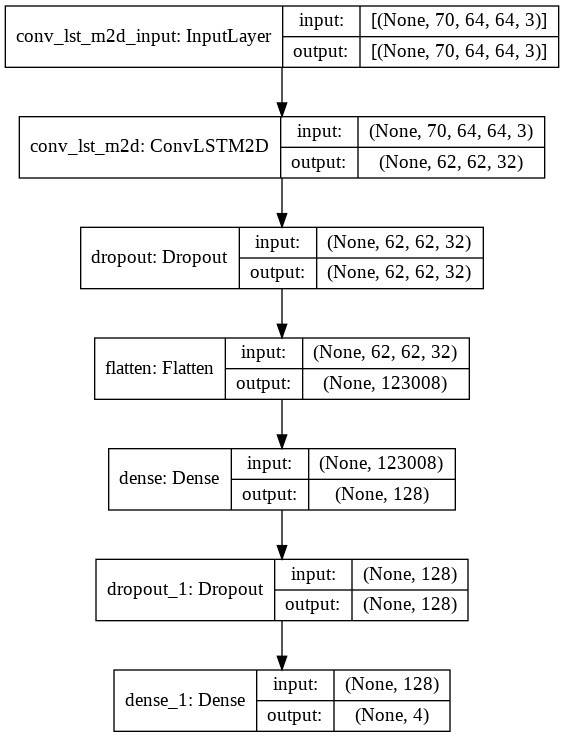

In [14]:
#Check Model’s Structure:
#Using the plot_model function you can check the structure of the final model, this is really helpful when you’re 
#creating a complex network and you want to make sure you have constructed the network correctly.
#import pydot
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)


# Step 6: Compile and Train the Model 
Compile the mode prior to training it 

In [15]:

# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(patience = 7)
callbacks = [early_stopping_callback]
# Adding loss, optimizer and metrics values to the model.
opt = keras.optimizers.SGD(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

model_training_history = model.fit(x = features_train, y = labels_train, epochs=15, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)
# Start Training


Epoch 1/15
42/42 [==============================] - 82s 1s/step - loss: 1.3734 - accuracy: 0.3414 - val_loss: 1.2583 - val_accuracy: 0.4819
Epoch 2/15
42/42 [==============================] - 50s 1s/step - loss: 1.2077 - accuracy: 0.4562 - val_loss: 1.1105 - val_accuracy: 0.6024
Epoch 3/15
42/42 [==============================] - 50s 1s/step - loss: 1.0729 - accuracy: 0.5801 - val_loss: 1.0556 - val_accuracy: 0.5301
Epoch 4/15
42/42 [==============================] - 50s 1s/step - loss: 0.8966 - accuracy: 0.6767 - val_loss: 1.0123 - val_accuracy: 0.5904
Epoch 5/15
42/42 [==============================] - 50s 1s/step - loss: 0.6881 - accuracy: 0.7764 - val_loss: 0.9334 - val_accuracy: 0.6747
Epoch 6/15
42/42 [==============================] - 50s 1s/step - loss: 0.5513 - accuracy: 0.8036 - val_loss: 0.6872 - val_accuracy: 0.6747
Epoch 7/15
42/42 [==============================] - 50s 1s/step - loss: 0.3041 - accuracy: 0.9003 - val_loss: 0.5739 - val_accuracy: 0.8193
Epoch 8/15
42/42 [==

In [16]:
#Evaluating Your Trained Model - Evaluate your trained model on the feature's and label's test sets.
model_evaluation_history = model.evaluate(features_test, labels_test)



4/4 [==============================] - 4s 851ms/step - loss: 0.4993 - accuracy: 0.8654


In [17]:
#save the model 
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)


# **Step 7: Plot Model’s Loss & Accuracy Curves**

Let's plot our loss and accuracy curves.

In [18]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

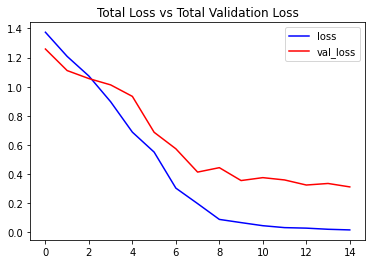

In [19]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


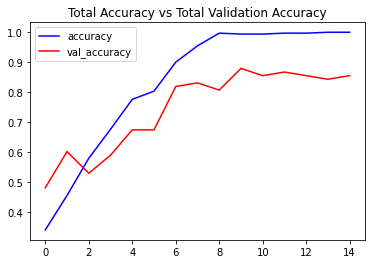

In [20]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


# **Step 8: Make Predictions with the Model:**
Now that we have created and trained our model it's time to test it's performance on some test videos.

**Function to Download Youtube videos:**
Let's start by testing on some youtube videos, this function will use pafy librar to download any youtube video and return it's title. You just need to pass the URL. 

In [21]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

**Function To Predict on Live Videos Using Moving Average:**


This function will predict on live videos using moving_average, you can either pass in videos saved on disk or use your webcam. If you set window_size hyperparameter to 1 then this function will behave like a normal classifier to predict on video frames.

Note: You can't use your webcam if you're running this notebook on google colab. 

In [22]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)
                # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

Download a Test Video:¶


In [23]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=WrUpeZ52A6E', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

**Results Without Using Moving Average:**
First let's see the results when we're not using moving average, we can do this by setting the window_size to 1. 

In [24]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1 #NOTE USING 1 WILL MEAN THAT WE DONT USE ROLLING AVERAGE 

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

ValueError: ignored

**Results When Using Moving Average:¶**

Now let's use moving average with a window size of 25.

In [ ]:
# Setting the Widow Size which will be used by the Rolling Averge Process
window_size = 25 

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Averge Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

#  Step 9: Using Single-Frame CNN Method:
 Now let's create a function that will output a singular prediction for the complete video, now this function will take n frames from the entire video and make predictions. In the end, it will average the predictions of those n frames to give you the final activity class for that video. You can set the value of n using the predictions_frames_count variable.

This function is useful when you have a video containing one activity and you want to know the activity's name and its score. 

In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

Test Average Prediction Method On Youtube Videos:¶
 

In [ ]:
# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=zaODx2oVW0w', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

In [ ]:
# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=sbZbBfAIadc', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

In [ ]:
# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=yspBuYeYOb0', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

In [ ]:
# Downloading The YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=KLrKksYIA4g', output_directory)

# Construting The Input YouTube Video Path
input_video_file_path = f'{output_directory}/{video_title}.mp4'

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)